<a href="https://colab.research.google.com/github/Selvakumar1904/AI-Based-Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

from sklearn import metrics
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
!pip install catboost

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Input, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys

# Get the absolute path of the current working directory
current_dir = os.getcwd()

# Assuming BalanceDataset.py is in the same directory as the current notebook
# If it's in a subfolder, adjust the path accordingly
# e.g., for a subfolder named 'utils': parent_dir = os.path.join(current_dir, 'utils')
parent_dir = current_dir

# Add the parent directory (or subfolder) to the Python path
sys.path.append(parent_dir)

# Now import the modules
import BalanceDataset as balance
import MachineLearningModels as ml_models
import DeepLearningModels as dl_models

import shap

## Dataset Description

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount - amount of the transaction in local currency.
- nameOrig - customer who started the transaction
- oldbalanceOrg - initial balance before the transaction
- newbalanceOrig - new balance after the transaction
- nameDest - customer who is the recipient of the transaction
- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [ ]:
data = pd.read_csv('Paysim.csv.zip')
df = data.copy()

In [ ]:

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
 df.duplicated().sum()

0

In [ ]:
df.nunique()

,0
step,743
type,5
amount,5316900
nameOrig,6353307
oldbalanceOrg,1845844
newbalanceOrig,2682586
nameDest,2722362
oldbalanceDest,3614697
newbalanceDest,3555499
isFraud,2


In [ ]:
df = df.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

In [ ]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [ ]:
#fig = px.box(df, y="amount")
#fig.show()

## EDA

In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [ ]:
# İşlemlerin yapıldığı kaynağın kontrol edilmesi.
transfer_df = df[((df['type']=='TRANSFER') & df['isFraud']==1)]
transfer_df['nameOrig'].value_counts()

,count
nameOrig,
C1305486145,1
C202278158,1
C12585107,1
C946427395,1
C1069177491,1
...,...
C2090764492,1
C1794935564,1
C318078280,1


In [ ]:
# İşlemlerin nakde çevrildiği varış noktasının kontrol edilmesi.
cash_out_fraud = df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)]
cash_out_fraud['nameDest'].value_counts()

,count
nameDest,
C200064275,2
C1399829166,2
C1650668671,2
C2129197098,2
C1013511446,2
...,...
C1566713324,1
C1955464150,1
C1104137869,1


In [ ]:
fraud_trans = df[df['isFraud'] == 1]
valid_trans = df[df['isFraud'] == 0]

trans_transfer = df[df['type'] == 'TRANSER']
trans_cashout = df[df['type'] == 'CASH_OUT']

print('Nakit çekmek için kullanılan alıcı hesabı var mı?')
trans_transfer.nameDest.isin(trans_cashout.nameOrig).any()

Nakit çekmek için kullanılan alıcı hesabı var mı?


False

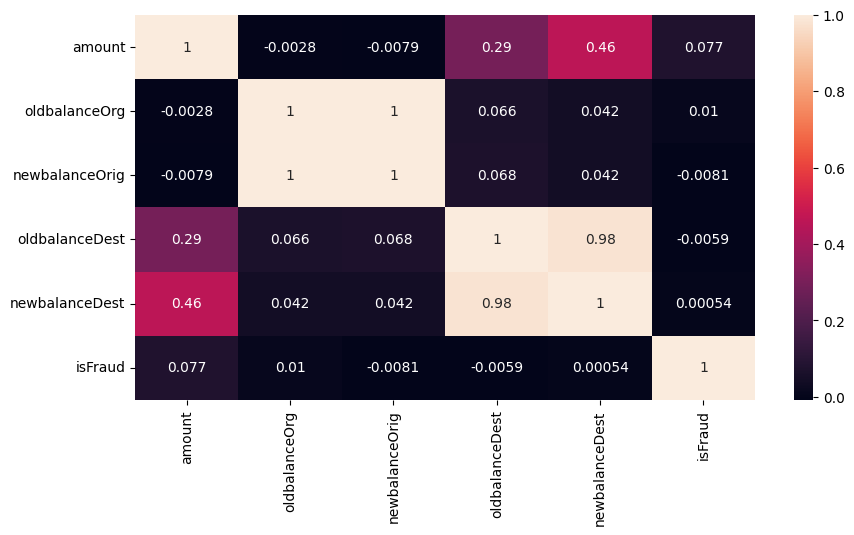

In [ ]:
plt.figure(figsize=(10,5))
# Only include numerical features for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(),annot=True);

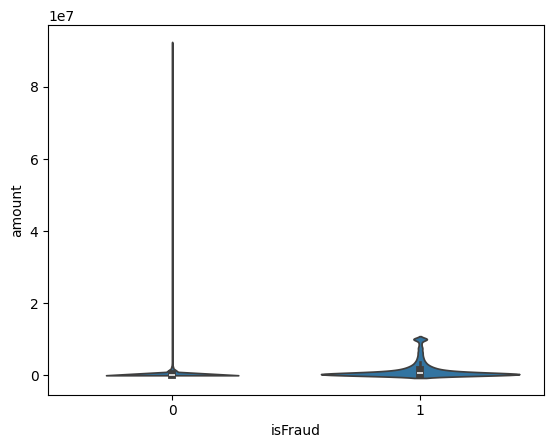

In [ ]:
sns.violinplot(x = df['isFraud'],y = df['amount']);

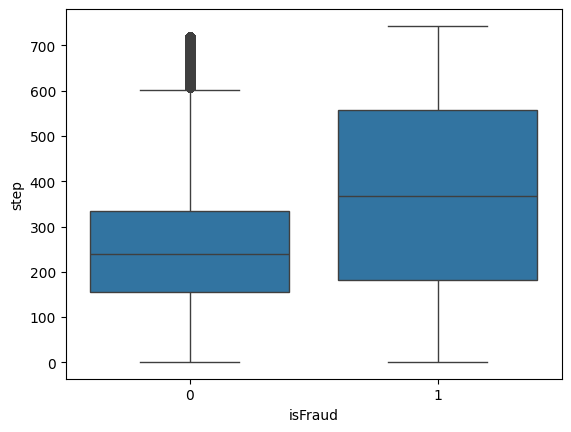

In [ ]:
#sns.boxplot(x=df.isFraud,y=df.step);
df_with_step = data.copy()  # Create a copy of the original data
df = df_with_step.drop(columns=['step', 'isFlaggedFraud'], axis='columns')  # Drop from original df

# ... (rest of your code) ...

sns.boxplot(x=df_with_step.isFraud, y=df_with_step.step);  # Use df_with_step for the plot

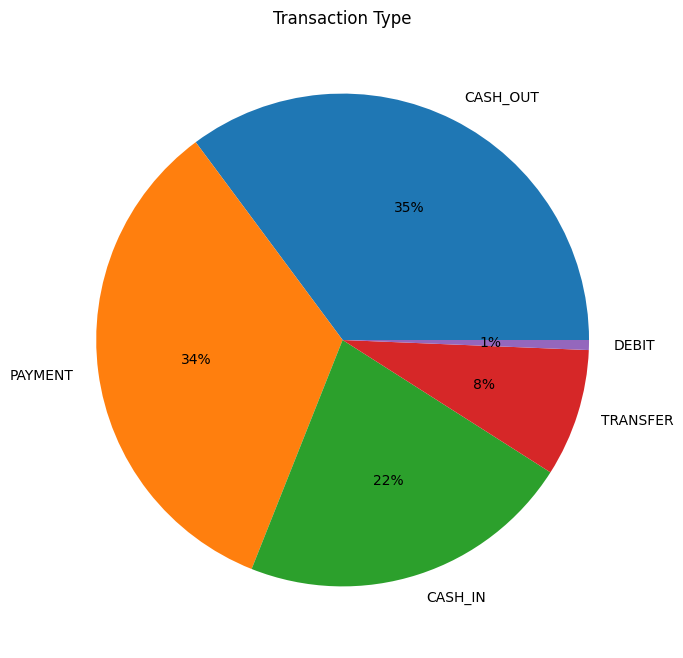

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(df.type.value_counts().values,labels=df.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = {}
for i in df.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    df[i] = encoder[i].fit_transform(df[i])

df=pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
df.drop(['type'],axis=1,inplace = True)

df.head()

## Preprocessing

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns.size

9

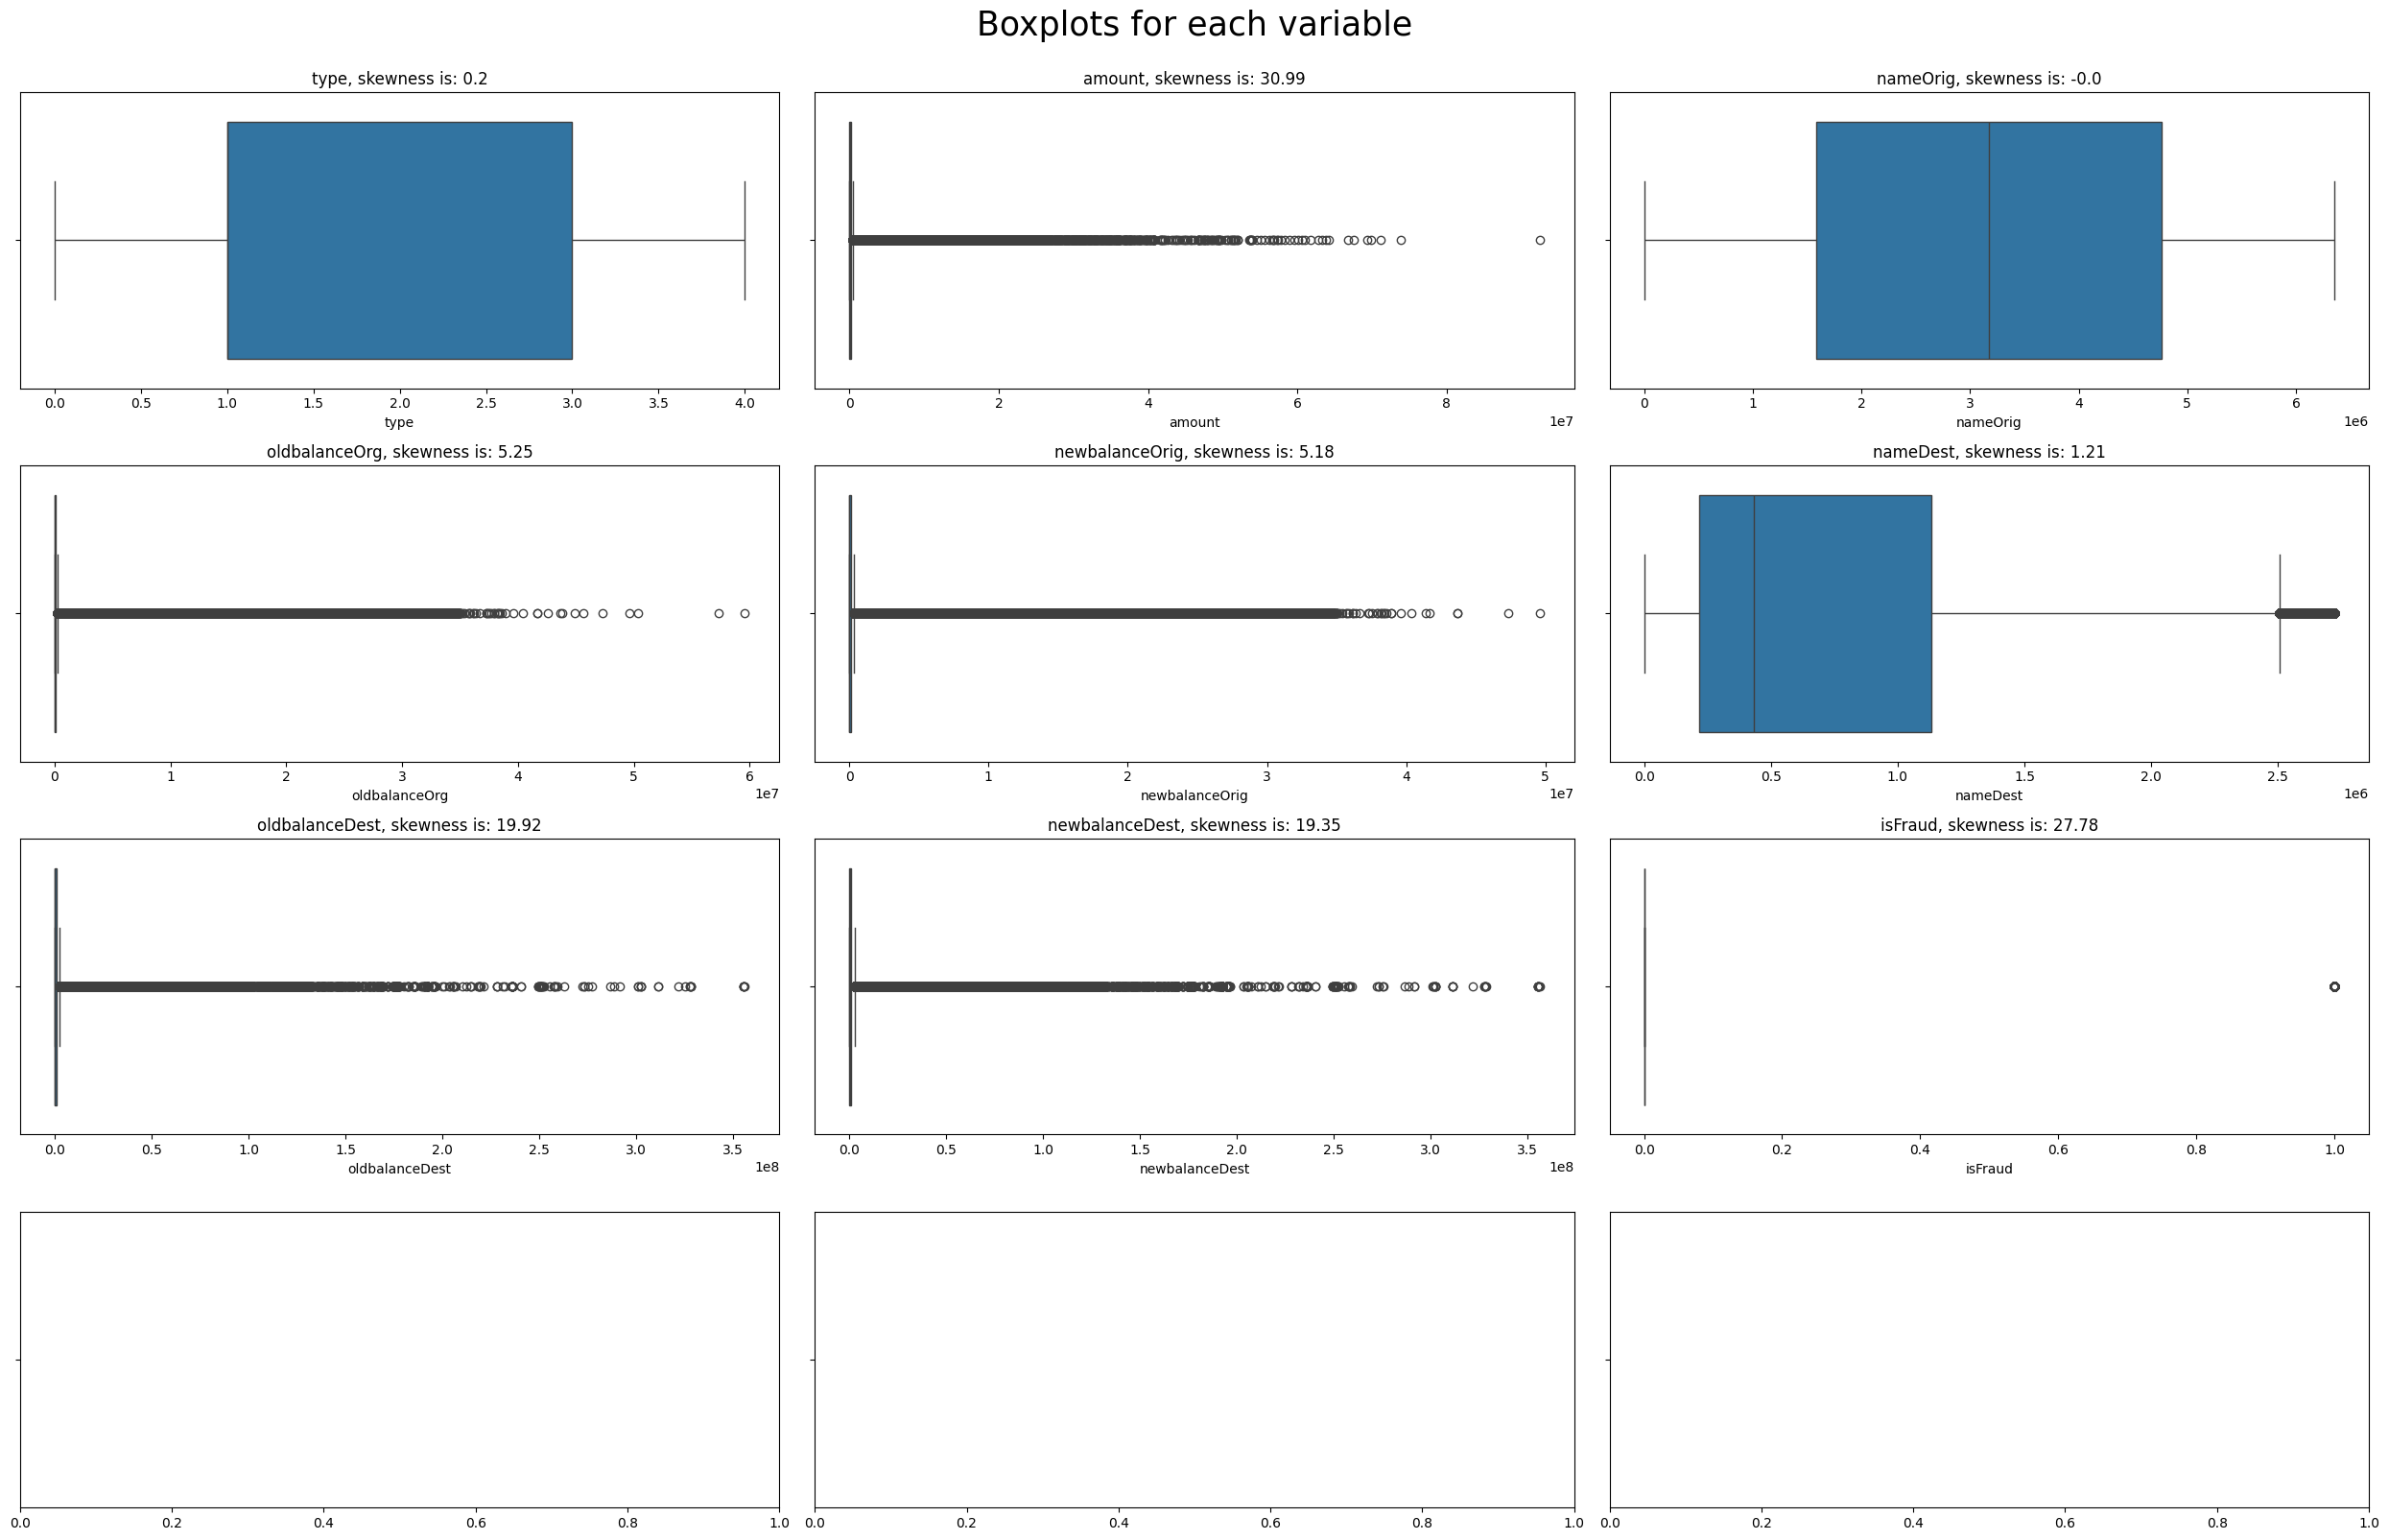

In [ ]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(25,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(dataset=df, columns_list=numeric_columns, rows=int(numeric_columns.size/3)+1, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

## Feature Engineering (chi2, ANNOVA)

### ...

## Model Oluşturma

In [ ]:
#df.drop(columns=['type','nameOrig','nameDest'], inplace=True)
df.drop(columns=['nameOrig','nameDest'], inplace=True)

In [ ]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [ ]:
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_chi2, y, test_size = 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, stratify=y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train_ros, y_train_ros = balance.balancedWithRandomOverSampler(X_train,y_train)

Non-Frauds: 4448085 / 50.0 % of the dataset
Frauds: 4448085 / 50.0 % of the dataset


In [ ]:
X_train_rus, y_train_rus = balance.balancedWithRandomUnderSampler(X_train,y_train)

Non-Frauds: 5749 / 50.0 % of the dataset
Frauds: 5749 / 50.0 % of the dataset


In [ ]:
X_train_smote, y_train_smote = balance.balanceWithSMOTE(X_train, y_train)

Non-Frauds: 4448085 / 50.0 % of the dataset
Frauds: 4448085 / 50.0 % of the dataset


In [ ]:
X_train_adasyn, y_train_adasyn = balance.balanceWithADASYN(X_train, y_train)

Non-Frauds: 4448085 / 50.0 % of the dataset
Frauds: 4448015 / 50.0 % of the dataset


# DEEP LEARNING

## Preprocessing

In [ ]:
dl_model_performances= pd.DataFrame(columns=["model_name","precision","recall","f1_score","AUC"])

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
parameters={
    'X_train_scaled' : X_train_scaled,
    'X_test_scaled' : X_test_scaled,
    'y_train' : y_train,
    'y_test' : y_test
}

In [ ]:
dl_models_list= [
            dl_models.ANN_model(**parameters),
            dl_models.RNN_model(**parameters),
            dl_models.LSTM_model(**parameters)

]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - auc: 0.8094 - loss: 0.0121 - precision: 0.7200 - recall: 0.3235 - val_auc: 0.9098 - val_loss: 0.0031 - val_precision: 0.9735 - val_recall: 0.5250
Epoch 2/10
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 134s 3ms/step - auc: 0.9202 - loss: 0.0033 - precision: 0.9344 - recall: 0.5633 - val_auc: 0.9691 - val_loss: 0.0025 - val_precision: 0.9536 - val_recall: 0.6440
Epoch 3/10
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - auc: 0.9347 - loss: 0.0028 - precision: 0.9354 - recall: 0.6258 - val_auc: 0.9194 - val_loss: 0.0028 - val_precision: 0.9812 - val_recall: 0.6064
Epoch 4/10
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - auc: 0.9423 - loss: 0.0031 - precision: 0.9385 - recall: 0.6216 - val_auc: 0.9445 - val_loss: 0.0031 - val_precision: 0.7049 - val_recall: 0.6986
Epoch 5/10
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 150s 4ms/step - auc: 0.9439 - loss: 0.0026 - precision: 0.9426 - recall: 0.6295 - val_auc: 0.9809 - val_loss: 0.0024 - val_precision: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
34796/34796 ━━━━━━━━━━━━━━━━━━━━ 248s 7ms/step - auc: 0.8843 - loss: 0.0214 - precision: 0.9502 - recall: 0.5013 - val_auc: 0.8910 - val_loss: 0.0034 - val_precision: 0.9865 - val_recall: 0.4748
Epoch 2/10
34796/34796 ━━━━━━━━━━━━━━━━━━━━ 257s 7ms/step - auc: 0.9150 - loss: 0.0032 - precision: 0.9674 - recall: 0.5260 - val_auc: 0.9046 - val_loss: 0.0030 - val_precision: 0.9762 - val_recall: 0.5170
Epoch 3/10
34796/34796 ━━━━━━━━━━━━━━━━━━━━ 230s 7ms/step - auc: 0.9334 - loss: 0.0027 - precision: 0.9690 - recall: 0.5853 - val_auc: 0.9840 - val_loss: 0.0031 - val_precision: 0.9176 - val_recall: 0.6644
Epoch 4/10
34796/34796 ━━━━━━━━━━━━━━━━━━━━ 268s 7ms/step - auc: 0.9421 - loss: 0.0026 - precision: 0.9649 - recall: 0.6061 - val_auc: 0.9446 - val_loss: 0.0024 - val_precision: 0.9420 - val_recall: 0.6262
Epoch 5/10
34796/34796 ━━━━━━━━━━━━━━━━━━━━ 241s 7ms/step - auc: 0.9504 - loss: 0.0025 - precision: 0.9699 - recall: 0.6323 - val_auc: 0.9309 - val_loss: 0.0024 - val_precision

In [ ]:
for i in range(len(dl_models_list)): # Change dl_models to dl_models_list
        dl_model_performances.loc[len(dl_model_performances.index)] = dl_models_list[i] # Change dl_models to dl_models_list

In [ ]:
dl_model_performances.sort_values(by=['f1_score','AUC'],
                                  ascending=False).reset_index(drop=True)

,model_name,precision,recall,f1_score,AUC
0,ANN,0.942497,0.698458,0.802331,0.945127
1,RNN,0.955443,0.687500,0.799622,0.971210
2,LSTM,0.913627,0.691153,0.786969,0.977777


In [ ]:
final_result = pd.concat([ dl_model_performances])

In [ ]:
final_result.sort_values(by=['f1_score','AUC'],
                                  ascending=False).reset_index(drop=True)

,model_name,precision,recall,f1_score,AUC
0,ANN,0.942497,0.698458,0.802331,0.945127
1,RNN,0.955443,0.687500,0.799622,0.971210
2,LSTM,0.913627,0.691153,0.786969,0.977777


In [ ]:
dl_model_performances

,model_name,precision,recall,f1_score,AUC
0,ANN,0.942497,0.698458,0.802331,0.945127
1,RNN,0.955443,0.687500,0.799622,0.971210
2,LSTM,0.913627,0.691153,0.786969,0.977777


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Create the Autoencoder model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(X_train.shape[1], activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
model.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_test, X_test))

# Use the trained Autoencoder for anomaly detection
reconstructed_data = model.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed_data, 2), axis=1)
threshold = np.mean(mse) + np.std(mse)  # Define a threshold for anomaly detection

# Classify instances as fraudulent or non-fraudulent based on the threshold
y_pred = [1 if error > threshold else 0 for error in mse]

# Evaluate the model
accuracy = np.mean(np.equal(y_test, y_pred))
print("Accuracy:", accuracy)


Epoch 1/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 214s 3ms/step - loss: 0.0963 - val_loss: 0.0882
Epoch 2/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 182s 3ms/step - loss: 0.0882 - val_loss: 0.0882
Epoch 3/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 197s 3ms/step - loss: 0.0882 - val_loss: 0.0882
Epoch 4/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 189s 3ms/step - loss: 0.0882 - val_loss: 0.0882
Epoch 5/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 199s 3ms/step - loss: 0.0882 - val_loss: 0.0882
Epoch 6/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 179s 3ms/step - loss: 0.0882 - val_loss: 0.0882
Epoch 7/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 182s 3ms/step - loss: 0.0882 - val_loss: 0.0882
Epoch 8/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 207s 3ms/step - loss: 0.0882 - val_loss: 0.0882
Epoch 9/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 183s 3ms/step - loss: 0.0882 - val_loss: 0.0882
Epoch 10/10
69592/69592 ━━━━━━━━━━━━━━━━━━━━ 201s 3ms/step - loss: 0.0882 - val_loss: 0.0882
59650/59650 ━━━━━━━━━━━━━━━━━━━━ 92s 2ms/step
Accuracy: 0.9978845192703635


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the sample dataset
sample_data = pd.read_csv('sample_fraud_detection.csv')

# Display dataset information
print(sample_data.info())
print(sample_data.head())

# Preprocessing
# Label encode the 'type' column (use the same encoder as in the original model code)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
sample_data['type'] = encoder.fit_transform(sample_data['type'])

# Drop any columns not used for model prediction
sample_data = sample_data.drop(['isFlaggedFraud'], axis=1)

# Scale the data
scaler = MinMaxScaler()
sample_data_scaled = scaler.fit_transform(sample_data.drop('isFraud', axis=1))

# Features (X) and labels (y)
X_sample = sample_data_scaled
y_sample = sample_data['isFraud']

print("Preprocessed sample data ready for testing.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            9 non-null      object 
 1   amount          9 non-null      float64
 2   oldbalanceOrg   9 non-null      float64
 3   newbalanceOrig  9 non-null      float64
 4   oldbalanceDest  9 non-null      float64
 5   newbalanceDest  9 non-null      float64
 6   isFraud         9 non-null      int64  
 7   isFlaggedFraud  9 non-null      int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 704.0+ bytes
None
       type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  TRANSFER     181.0         1000.0           819.0             0.0   
1  CASH_OUT     120.0          120.0             0.0             0.0   
2  TRANSFER  200000.0       200000.0             0.0             0.0   
3  CASH_OUT    5000.0        10000.0          5000.0             0.0   
4   PAYMENT     10

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained ANN, RNN, or LSTM model
model = load_model('fraud_detection_model.h5')  # Replace with your model's file name

# Check model structure
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 840 (3.29 KB)

 Trainable params: 838 (3.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Predict fraud on the sample dataset
predictions = model.predict(X_sample)

# Convert probabilities to binary labels (0 or 1)
predictions_binary = (predictions > 0.5).astype(int)

# Compare predictions with true labels
for i in range(len(y_sample)):
    print(f"Transaction {i+1}: Actual={y_sample.iloc[i]}, Predicted={predictions_binary[i][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Transaction 1: Actual=1, Predicted=1
Transaction 2: Actual=0, Predicted=0
Transaction 3: Actual=1, Predicted=1
Transaction 4: Actual=0, Predicted=0
Transaction 5: Actual=0, Predicted=1
Transaction 6: Actual=0, Predicted=1
Transaction 7: Actual=0, Predicted=0
Transaction 8: Actual=1, Predicted=1
Transaction 9: Actual=0, Predicted=0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Transaction 1: Actual=1, Predicted=Fraud (Probability: 1.0000)
Transaction 2: Actual=0, Predicted=Non-Fraud (Probability: 0.2503)
Transaction 3: Actual=1, Predicted=Fraud (Probability: 1.0000)
Transaction 4: Actual=0, Predicted=Non-Fraud (Probability: 0.0541)
Transaction 5: Actual=0, Predicted=Fraud (Probability: 0.7671)
Transaction 6: Actual=0, Predicted=Fraud (Probability: 0.5357)
Transaction 7: Actual=0, Predicted=Non-Fraud (Probability: 0.0000)
Transaction 8: Actual=1, Predicted=Fraud (Probability: 1.0000)
Transaction 9: Actual=0, Predicted=Non-Fraud (Probability: 0.2506)
